In [1]:
import requests
import json
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [21]:
import requests

def requete_nom_propriete(code_item, code_propriete, langue) :
    req = """SELECT ?prop ?propLabel
    WHERE {
      wd:%s ?p wd:%s .
      ?prop wikibase:directClaim ?p .
      SERVICE wikibase:label {
            bd:serviceParam wikibase:language "%s" .
      }
    }""" % (code_item, code_propriete, langue)
    
    par = {
    "query" : req,
    "format" : "json"
    }
    r = requests.get("https://query.wikidata.org/sparql", params=par)

    dico = r.json()
    
    return dico["results"]["bindings"][0]["propLabel"]["value"]

def requete_liste_proprietes(code_item, langue):
    req = """SELECT DISTINCT ?objet ?objetLabel
    WHERE {
      wd:%s ?p ?objet .
      ?objet rdfs:label ?l .
      SERVICE wikibase:label {
            bd:serviceParam wikibase:language "%s" .
      }
    }""" % (code_item, langue)

    par = {
        "query" : req,
        "format" : "json"
    }
    r = requests.get("https://query.wikidata.org/sparql", params=par)

    dico = r.json()
    return dico["results"]["bindings"]

import time

def liste_proprietes(code_item, dico_ranks, langue):
    dic = requete_liste_proprietes(code_item, langue)
    ranks = []
    # Classement des 5 propriétés les plus pertinentes selon les pageRanks
    for propriete in dic:
        uri_objet = propriete["objet"]["value"]
        label_objet = propriete["objetLabel"]["value"]
        code_objet = uri_objet.split("/")[-1]
        if code_objet[1:] in dico_ranks:
            ranks.append((float(dico_ranks[code_objet[1:]]), code_objet, label_objet))
    classement = sorted(ranks, reverse=True)
    mots_nuage = [el[2] for el in classement]
    top = [(el[1], el[2]) for el in classement[:5]]
    #print(classement)
    # Récupération des noms des propriétés
    for propriete in top:
        label_objet = propriete[1]
        code_objet = propriete[0]
        valeur_propriete = requete_nom_propriete(code_item, code_objet, langue)
        if valeur_propriete == "sous-classe de":
            valeur_propriete = "type"
        valeur_propriete = valeur_propriete.capitalize()
        print("%s : %s" % (valeur_propriete, label_objet), end=" | ")
        time.sleep(1.5)
    return mots_nuage

def nuage_de_mots(liste_mots, taille_min, chemin):
    nuage = ""
    s = " -"
    for mot in liste_mots:
        for char in s:
            if char in mot:
                mot = mot.replace(char, "_")
        nuage += mot + " "
    wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white',
                min_font_size = taille_min).generate(nuage)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    #plt.show()
    plt.savefig("%s.png" % chemin)

In [3]:
# chargement du dictionnaire des pageRanks

import json

file = open("PageRanks/ranks.json", "r", encoding="utf-8")
dico_ranks = json.load(file)
file.close()

In [23]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('Données_mémoire/peintures_word2vec.txt')
#glove_file = datapath('Données_mémoire/fromages_word2vec.txt')
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

In [5]:
par2 = {
    "action" : "wbsearchentities",
    "format" : "json",
    "language" : "fr"
}

In [24]:
positifs = []
negatifs = []

saisie = input("A partir de quelle entité voulez-vous obtenir une recommandation ? (0 pour sortir) ")

while saisie != "0":
    positifs.append(saisie)
    saisie = input("Nouvelle entrée pour la recommandation : (0 pour sortir)")

saisie = input("Voulez-vous ajouter une entité que vous ne voulez pas avoir comme recommandation ? (0 pour sortir) ")

while saisie != "0":
    negatifs.append(saisie)
    saisie = input("Nouvelle entrée à ne pas recommander ? : (0 pour sortir)")

recherche = [positifs] + [negatifs]

print(recherche)

A partir de quelle entité voulez-vous obtenir une recommandation ? (0 pour sortir) La Naissance de vénus
Nouvelle entrée pour la recommandation : (0 pour sortir)0
Voulez-vous ajouter une entité que vous ne voulez pas avoir comme recommandation ? (0 pour sortir) 0
[['La Naissance de vénus'], []]


In [25]:
pos_neg = []

for i in range (len(recherche)):
    pos_neg.append([])
    for el in recherche[i]:
        par2["search"] = el
        r = requests.get("https://www.wikidata.org/w/api.php", params=par2)
        #print(r.url)
        d = r.json()
        for j in range(0, len(d["search"])):
            url_entite = d["search"][j]["concepturi"]
            if "<%s>" % url_entite in model.index2word:
                identifiant = d["search"][j]["id"]
                pos_neg[i].append('<http://www.wikidata.org/entity/%s>' % identifiant)
                break
    
print(pos_neg)
res = model.most_similar(positive=pos_neg[0], negative=pos_neg[1], topn=5)

[['<http://www.wikidata.org/entity/Q151047>'], []]


In [26]:
import re

#labels = open("Labels/liste_labels_fromages.json", "r", encoding="utf-8")
labels = open("Labels/liste_labels_peintures.json", "r", encoding="utf-8")
dic_labels = json.load(labels)
labels.close()

liste_mots_nuage = []

langue = "fr"

for el in res:
    print("-"*10)
    entite = el[0][1:-1]
    code_item = entite.split("/")[-1]
    if entite in dic_labels:
        label = dic_labels[entite]
    if (re.match("Q[0-9]+", label)):
        label += " (Pas de label pour cette entité)"
    print(label)
    print("Score : %.3f " % el[1])
    print(entite)
    liste_mots_nuage += liste_proprietes(code_item, dico_ranks, langue)
    print()
    
#nuage_de_mots(liste_mots_nuage)

----------
Léda et le Cygne
Score : 0.668 
http://www.wikidata.org/entity/Q11753618
Pays : Italie | Statut des droits d'auteur : domaine public | Dépeint : femme | Dépeint : chien | Dépeint : chat domestique | 
----------
Retable de San Marco
Score : 0.662 
http://www.wikidata.org/entity/Q1131263
Pays : Italie | Religion : christianisme | Statut des droits d'auteur : domaine public | Dépeint : Jésus-Christ | Dépeint : femme | 
----------
La Découverte du cadavre d'Holopherne
Score : 0.660 
http://www.wikidata.org/entity/Q7885787
Pays : Italie | Religion : christianisme | Statut des droits d'auteur : domaine public | Matériau : bois | Dépeint : cheval | 
----------
Pallas et le Centaure
Score : 0.652 
http://www.wikidata.org/entity/Q2426058
Pays : Italie | Statut des droits d'auteur : domaine public | Basé sur : mythologie grecque | Nature de l'élément : peinture | Créateur : Sandro Botticelli | 
----------
Vierge à l'Enfant entre sainte Catherine et Marie de Magdala
Score : 0.646 
http

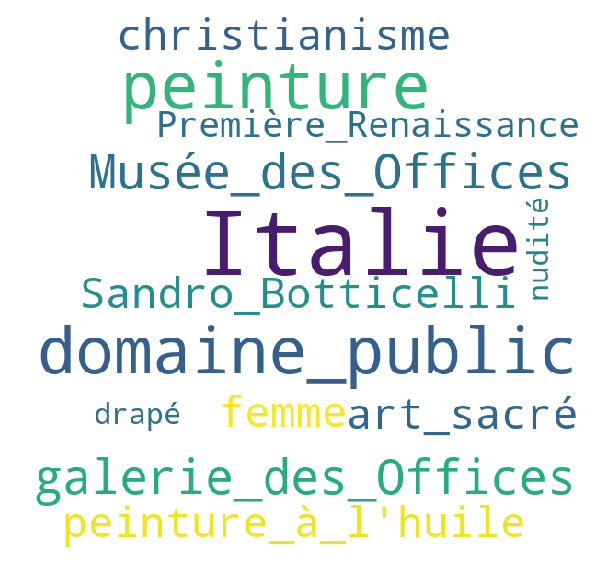

In [31]:
nuage_de_mots(liste_mots_nuage, 30, "Nuages/Peintures_Vénus")

In [10]:
liste_proprietes("Q131480", dico_ranks, "fr")

Pays : France | Matériau : lait | Lieu de fabrication : Normandie | Type : fromage | Matériau : lait de vache | 

['France',
 'lait',
 'Normandie',
 'fromage',
 'lait de vache',
 'fromage français',
 'Camembert',
 'fromage au lait de vache',
 'fromage à pâte molle à croûte fleurie',
 'Marie Harel',
 'fromage industriel',
 'Catégorie:Camembert (fromage)']

In [33]:
print(len(liste_mots_nuage))

109
